In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np


In [ ]:
def get_Prime_number_in_a_range(start, end):
    Prime_list = []
    for val in range(start, end + 1): 
        prime_or_not = True
        for n in range(2, val):
            if (val % n) == 0:
                prime_or_not = False
                break
        if prime_or_not:
            Prime_list.append(val)
    return Prime_list


def get_out_channel_number(paramenter_layer, in_channel, prime_list):
    out_channel_expect = int(paramenter_layer/(in_channel*sum(prime_list)))
    return out_channel_expect



def generate_layer_parameter_list(start,end,paramenter_number_of_layer_list, in_channel = 1):
    prime_list = get_Prime_number_in_a_range(start, end)
    if prime_list == []:
        print('start = ',start, 'which is larger than end = ', end)
    input_in_channel = in_channel
    layer_parameter_list = []
    for paramenter_number_of_layer in paramenter_number_of_layer_list:
        out_channel = get_out_channel_number(paramenter_number_of_layer, in_channel, prime_list)
        
        tuples_in_layer= []
        for prime in prime_list:
            tuples_in_layer.append((in_channel,out_channel,prime))
        in_channel =  len(prime_list)*out_channel
        
        layer_parameter_list.append(tuples_in_layer)
    
    tuples_in_layer_last = []
    first_out_channel = len(prime_list)*get_out_channel_number(paramenter_number_of_layer_list[0], input_in_channel, prime_list)
    tuples_in_layer_last.append((in_channel,first_out_channel,start))
    tuples_in_layer_last.append((in_channel,first_out_channel,start+1))
    layer_parameter_list.append(tuples_in_layer_last)
    return layer_parameter_list

In [ ]:
get_Prime_number_in_a_range(2, 10)

[2, 3, 5, 7]

In [ ]:
def calculate_mask_index(kernel_length_now,largest_kernel_lenght):
    right_zero_mast_length = math.ceil((largest_kernel_lenght-1)/2)-math.ceil((kernel_length_now-1)/2)
    left_zero_mask_length = largest_kernel_lenght - kernel_length_now - right_zero_mast_length
    return left_zero_mask_length, left_zero_mask_length+ kernel_length_now

def creat_mask(number_of_input_channel,number_of_output_channel, kernel_length_now, largest_kernel_lenght):
    ind_left, ind_right= calculate_mask_index(kernel_length_now,largest_kernel_lenght)
    mask = np.ones((number_of_input_channel,number_of_output_channel,largest_kernel_lenght))
    mask[:,:,0:ind_left]=0
    mask[:,:,ind_right:]=0
    return mask


def creak_layer_mask(layer_parameter_list):
    largest_kernel_lenght = layer_parameter_list[-1][-1]
    mask_list = []
    init_weight_list = []
    bias_list = []
    for i in layer_parameter_list:
        conv = torch.nn.Conv1d(in_channels=i[0], out_channels=i[1], kernel_size=i[2])
        ind_l,ind_r= calculate_mask_index(i[2],largest_kernel_lenght)
        big_weight = np.zeros((i[1],i[0],largest_kernel_lenght))
        big_weight[:,:,ind_l:ind_r]= conv.weight.detach().numpy()
        
        bias_list.append(conv.bias.detach().numpy())
        init_weight_list.append(big_weight)
        
        mask = creat_mask(i[1],i[0],i[2], largest_kernel_lenght)
        mask_list.append(mask)
        
    mask = np.concatenate(mask_list, axis=0)
    init_weight = np.concatenate(init_weight_list, axis=0)
    init_bias = np.concatenate(bias_list, axis=0)
    return mask.astype(np.float32), init_weight.astype(np.float32), init_bias.astype(np.float32)

    
class build_layer_with_layer_parameter(nn.Module):
    def __init__(self,layer_parameters):
        super(build_layer_with_layer_parameter, self).__init__()

        os_mask, init_weight, init_bias= creak_layer_mask(layer_parameters)
        
        
        in_channels = os_mask.shape[1] 
        out_channels = os_mask.shape[0] 
        max_kernel_size = os_mask.shape[-1]

        self.weight_mask = nn.Parameter(torch.from_numpy(os_mask),requires_grad=False)
        
        self.padding = nn.ConstantPad1d((int((max_kernel_size-1)/2), int(max_kernel_size/2)), 0)
         
        self.conv1d = torch.nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=max_kernel_size)
        self.conv1d.weight = nn.Parameter(torch.from_numpy(init_weight),requires_grad=True)
        self.conv1d.bias =  nn.Parameter(torch.from_numpy(init_bias),requires_grad=True)

        self.bn = nn.BatchNorm1d(num_features=out_channels)
    
    def forward(self, X):
        self.conv1d.weight.data = self.conv1d.weight*self.weight_mask
        #self.conv1d.weight.data.mul_(self.weight_mask)
        result_1 = self.padding(X)
        result_2 = self.conv1d(result_1)
        result_3 = self.bn(result_2)
        result = F.relu(result_3)
        return result    
    
class OS_CNN(nn.Module):
    def __init__(self,layer_parameter_list,n_class,few_shot = True):
        super(OS_CNN, self).__init__()
        self.few_shot = few_shot
        self.layer_parameter_list = layer_parameter_list
        self.layer_list = []
        
        
        for i in range(len(layer_parameter_list)):
            layer = build_layer_with_layer_parameter(layer_parameter_list[i])
            self.layer_list.append(layer)
        
        self.net = nn.Sequential(*self.layer_list)
            
        self.averagepool = nn.AdaptiveAvgPool1d(1)
        
        out_put_channel_numebr = 0
        for final_layer_parameters in layer_parameter_list[-1]:
            out_put_channel_numebr = out_put_channel_numebr+ final_layer_parameters[1] 
            
        self.hidden = nn.Linear(out_put_channel_numebr, n_class)

    def forward(self, X):
        
        X = self.net(X)

        X = self.averagepool(X)
        X = X.squeeze_(-1)

        if not self.few_shot:
            X = self.hidden(X)
        return X
        

In [ ]:
import os
from sklearn.metrics import accuracy_score
from os.path import dirname
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset



class OS_CNN_easy_use():

    def __init__(self,
                 device,
                 start_kernel_size = 1,
                 Max_kernel_size = 100,
                 paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],
                 max_epoch = 2000,
                 batch_size=16,
                 print_result_every_x_epoch = 50,
                 learning_rate = 0.001
                ):

        super(OS_CNN_easy_use, self).__init__()

        
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")

        self.start_kernel_size = start_kernel_size
        self.Max_kernel_size = Max_kernel_size
        self.paramenter_number_of_layer_list = paramenter_number_of_layer_list
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.print_result_every_x_epoch = print_result_every_x_epoch
        self.learning_rate = learning_rate

        self.OS_CNN = None


    def fit(self, X_train, y_train, X_val, y_val):

        print('code is running on ',self.device)


        # covert numpy to pytorch tensor and put into gpu
        X_train = torch.from_numpy(X_train)
        X_train.requires_grad = False
        X_train = X_train.to(self.device)
        y_train = torch.from_numpy(y_train).to(self.device)


        X_test = torch.from_numpy(X_val)
        X_test.requires_grad = False
        X_test = X_test.to(self.device)
        y_test = torch.from_numpy(y_val).to(self.device)


        # add channel dimension to time series data
        if len(X_train.shape) == 2:
            X_train = X_train.unsqueeze_(1)
            X_test = X_test.unsqueeze_(1)

        input_shape = X_train.shape[-1]
        n_class = max(y_train) + 1
        receptive_field_shape= min(int(X_train.shape[-1]/4),self.Max_kernel_size)

        # generate parameter list
        layer_parameter_list = generate_layer_parameter_list(self.start_kernel_size,
                                                             receptive_field_shape,
                                                             self.paramenter_number_of_layer_list,
                                                             in_channel = int(X_train.shape[1]))


        torch_OS_CNN = OS_CNN(layer_parameter_list, n_class.item(), False).to(self.device)

        # save_initial_weight
        #torch.save(torch_OS_CNN.state_dict(), self.Initial_model_path)


        # loss, optimizer, scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(torch_OS_CNN.parameters(),lr=self.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=0.0001)

        # build dataloader

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=max(int(min(X_train.shape[0] / 10, self.batch_size)),2), shuffle=True)
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=max(int(min(X_train.shape[0] / 10, self.batch_size)),2), shuffle=False)


        torch_OS_CNN.train()

        for i in range(self.max_epoch):
            for sample in train_loader:
                optimizer.zero_grad()
                y_predict = torch_OS_CNN(sample[0])
                output = criterion(y_predict, sample[1])
                output.backward()
                optimizer.step()
            scheduler.step(output)

            if eval_condition(i,self.print_result_every_x_epoch):
                for param_group in optimizer.param_groups:
                    print('epoch =',i, 'lr = ', param_group['lr'])
                torch_OS_CNN.eval()
                acc_train = eval_model(torch_OS_CNN, train_loader)
                acc_test = eval_model(torch_OS_CNN, test_loader)
                torch_OS_CNN.train()
                print('train_acc=\t', acc_train, '\t test_acc=\t', acc_test, '\t loss=\t', output.item())
                sentence = 'train_acc=\t'+str(acc_train)+ '\t test_acc=\t'+str(acc_test)+'\t loss=\t'+str(output.item())
                #torch.save(torch_OS_CNN.state_dict(), self.model_save_path)

        #torch.save(torch_OS_CNN.state_dict(), self.model_save_path)
        self.OS_CNN = torch_OS_CNN



    def predict(self, X_test):

        X_test = torch.from_numpy(X_test)
        X_test.requires_grad = False
        X_test = X_test.to(self.device)

        if len(X_test.shape) == 2:
            X_test = X_test.unsqueeze_(1)

        test_dataset = TensorDataset(X_test)
        test_loader = DataLoader(test_dataset, batch_size=max(int(min(X_test.shape[0] / 10, self.batch_size)),2), shuffle=False)

        self.OS_CNN.eval()

        predict_list = np.array([])
        for sample in test_loader:
            y_predict = self.OS_CNN(sample[0])
            y_predict = y_predict.detach().cpu().numpy()
            y_predict = np.argmax(y_predict, axis=1)
            predict_list = np.concatenate((predict_list, y_predict), axis=0)

        return predict_list









In [ ]:
import os
from sklearn.metrics import accuracy_score
from os.path import dirname
import numpy as np


def eval_condition(iepoch,print_result_every_x_epoch):
    if (iepoch + 1) % print_result_every_x_epoch == 0:
        return True
    else:
        return False


def eval_model(model, dataloader):
    predict_list = np.array([])
    label_list = np.array([])
    for sample in dataloader:
        y_predict = model(sample[0])
        y_predict = y_predict.detach().cpu().numpy()
        y_predict = np.argmax(y_predict, axis=1)
        predict_list = np.concatenate((predict_list, y_predict), axis=0)
        label_list = np.concatenate((label_list, sample[1].detach().cpu().numpy()), axis=0)
    acc = accuracy_score(predict_list, label_list)
    return acc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from scipy.signal import resample
import seaborn as sns

CANVAS_HEIGHT = 400
CANVAS_LENGTH = 800
CANVAS_X_MIN = -80
CANVAS_X_MAX = 80
CANVAS_Y_MIN = -70
CANVAS_Y_MAX = 70
CANVAS_X_MULTIPLIER = CANVAS_LENGTH / (CANVAS_X_MAX - CANVAS_X_MIN)
CANVAS_Y_MULTIPLIER = -CANVAS_HEIGHT / (CANVAS_Y_MAX - CANVAS_Y_MIN)
RESAMPLE_VAL = 60

def decode_number2(number):
    switcher = { 0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7',
                 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E',
                 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L',
                 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S',
                 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
                 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h',
                 43: 'n', 44: 'q', 45: 'r', 46: 't' }
    return switcher.get(number,str(number))

def decode_number(number):
    switcher = { 0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7',
                 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E',
                 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L',
                 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S',
                 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
                 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g',
                 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n',
                 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u',
                 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'}
    return switcher.get(number,str(number))

def characters_47_classes_to_36(number):
    switcher = { 36: 10, 37: 11, 38: 13, 39: 14, 40: 15, 41: 16, 42: 17,
                 43: 23, 44: 26, 45: 27, 46: 29 }
    return switcher.get(number,number)

def char_to_num(symbol):
    switcher = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, 'A':10,
               'B':11, 'C':12, 'D':13, 'E':14, 'F':15, 'G':16, 'H':17, 'I':18, 'J':19, 'K':20, 'L':21,
               'M':22, 'N':23, 'O':24, 'P':25, 'Q':26, 'R':27, 'S':28, 'T':29, 'U':30, 'V':31, 'W':32,
               'X':33, 'Y':34, 'Z':35}
    return switcher.get(symbol,symbol)

def char_to_num2(symbol):
    switcher = {'a': 0, 'b':1, 'd':2, 'e':3, 'f':4, 'g':5, 'h':6, 'n':7, 'q':8,
                'r': 9, 't': 10, '0':11, '1':12, '2':13, '3':14, '4':15, '5':16,
                '6':17, '7':18, '8':19, '9':20, 'A':21, 'B':22, 'C':23, 'D':24,
                'E':25, 'F':26, 'G':27, 'H':28, 'I':29, 'J':30, 'K':31, 'L':32,
                'M':33, 'N':34, 'O':35, 'P':36, 'Q':37, 'R':38, 'S':39, 'T':40,
                'U':41, 'V':42, 'W':43, 'X':44, 'Y':45, 'Z':46}
    return switcher.get(symbol,symbol)

def characters_merged_37_classes(label):
    """ changes the lower case letter to upper case letters where upper
        and lower letters are similar
    label: ASCII character
        ASCII character a to z

    returns new ASCII character in upper case if letter is detected
    """
    switcher = { 'c': 'C', 'i': 'I', 'j': 'J', 'k': 'K', 'l': 'L', 'm': 'M',
                 'o': 'O', 'p': 'P', 's': 'S', 'u': 'U', 'v': 'V', 'w': 'W',
                 'x': 'X', 'y': 'Y', 'z': 'Z' }

    return switcher.get(label,label)


def characters_merged_26_classes(label):
    """ changes the lower case letter to upper case letters
    label: ASCII character
        ASCII character a to z

    returns new ASCII character in upper case if letter is detected
    """
    switcher = { 'a': 'A', 'b': 'B', 'c': 'C', 'd': 'D', 'e': 'E', 'f': 'F',
                 'g': 'G', 'h': 'H', 'i': 'I', 'j': 'J', 'k': 'K', 'l': 'L',
                 'm': 'M', 'n': 'N', 'o': 'O', 'p': 'P', 'q': 'Q', 'r': 'R',
                 's': 'S', 't': 'T', 'u': 'U', 'v': 'V', 'w': 'W', 'x': 'X',
                 'y': 'Y', 'z': 'Z' }

    return switcher.get(label,label)


def print_confusion_matrix(confusion_matrix, class_names, figsize = (50,50),
                           fontsize=14, normalize=True):
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        print("Normalized confusion matrix")
    else:
        fmt = 'd'
        print("Confusion matrix, without normalization")

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt= fmt)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


X = np.load("/content/W_W_Data.npy",allow_pickle=True)
Y = np.load("/content/W_Y_(62).npy",allow_pickle=True)

#X_test = np.load("/content/X_test.npy",allow_pickle=True)
#y_test = np.load("/content/y_test.npy",allow_pickle=True)

X_train, X_test, y_train , y_test  = train_test_split(X, Y, test_size = 0.30, random_state = 150, shuffle=True)
X_train, X_validate, y_train , y_validate  = train_test_split(X_train, y_train, test_size = 0.001, random_state = 150)

# creat model and log save place
model = OS_CNN_easy_use(
         # dataset_name for creat log under Result_log_folder
        device = "cuda:0",                     # Gpu
        max_epoch = 75,                        # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough
        paramenter_number_of_layer_list = [8*128*X_train.shape[1], 5*128*256 + 2*256*128],
        batch_size=64,
        print_result_every_x_epoch = 1,
        learning_rate=0.001
        )


X_train = np.asarray(X_train).astype('float32')
X_validate = np.asarray(X_validate).astype('float32')
X_test = np.asarray(X_test).astype('float32')

#y_train = tf.keras.utils.to_categorical(y_train)
#y_test = tf.keras.utils.to_categorical(y_test)

#y_train = np.asarray(y_train).astype('float32')
#y_test = np.asarray(y_test).astype('float32')



X_validate.shape
y_train = np.reshape(y_train,(9953,))
y_validate = np.reshape(y_validate,(10,))
y_test = np.reshape(y_test,(4270,))


#X_train = np.reshape(X_train,(9953,6,615))
#X_validate = np.reshape(X_validate,(10,6,615)).T
#X_test = np.reshape(X_test,(4270,6,615))

In [ ]:
history = model.fit(X_train, y_train,X_validate,y_validate)
y_predict = model.predict(X_test)



code is running on  cuda:0
epoch = 0 lr =  0.001
train_acc=	 0.10539535818346227 	 test_acc=	 0.2 	 loss=	 3.4797773361206055
epoch = 1 lr =  0.001
train_acc=	 0.2940821862754948 	 test_acc=	 0.1 	 loss=	 2.930297613143921
epoch = 2 lr =  0.001
train_acc=	 0.4275092936802974 	 test_acc=	 0.4 	 loss=	 2.608654022216797
epoch = 3 lr =  0.001
train_acc=	 0.5363207073244248 	 test_acc=	 0.5 	 loss=	 1.6875420808792114
epoch = 4 lr =  0.001
train_acc=	 0.5306942630362704 	 test_acc=	 0.5 	 loss=	 1.6305084228515625
epoch = 5 lr =  0.001
train_acc=	 0.5980106500552598 	 test_acc=	 0.6 	 loss=	 1.4880298376083374
epoch = 6 lr =  0.001
train_acc=	 0.6029337888073948 	 test_acc=	 0.6 	 loss=	 1.1657328605651855
epoch = 7 lr =  0.001
train_acc=	 0.6217220938410529 	 test_acc=	 0.5 	 loss=	 1.0989559888839722
epoch = 8 lr =  0.001
train_acc=	 0.6084597608761178 	 test_acc=	 0.7 	 loss=	 1.5144157409667969
epoch = 9 lr =  0.001
train_acc=	 0.6698482869486587 	 test_acc=	 0.5 	 loss=	 1.21763372421

In [ ]:
acc = accuracy_score(y_predict, y_test)
print(acc)


0.7297423887587822


In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy Score = ", accuracy_score(y_test, y_predict))

Accuracy Score =  0.7255269320843092


Normalized confusion matrix


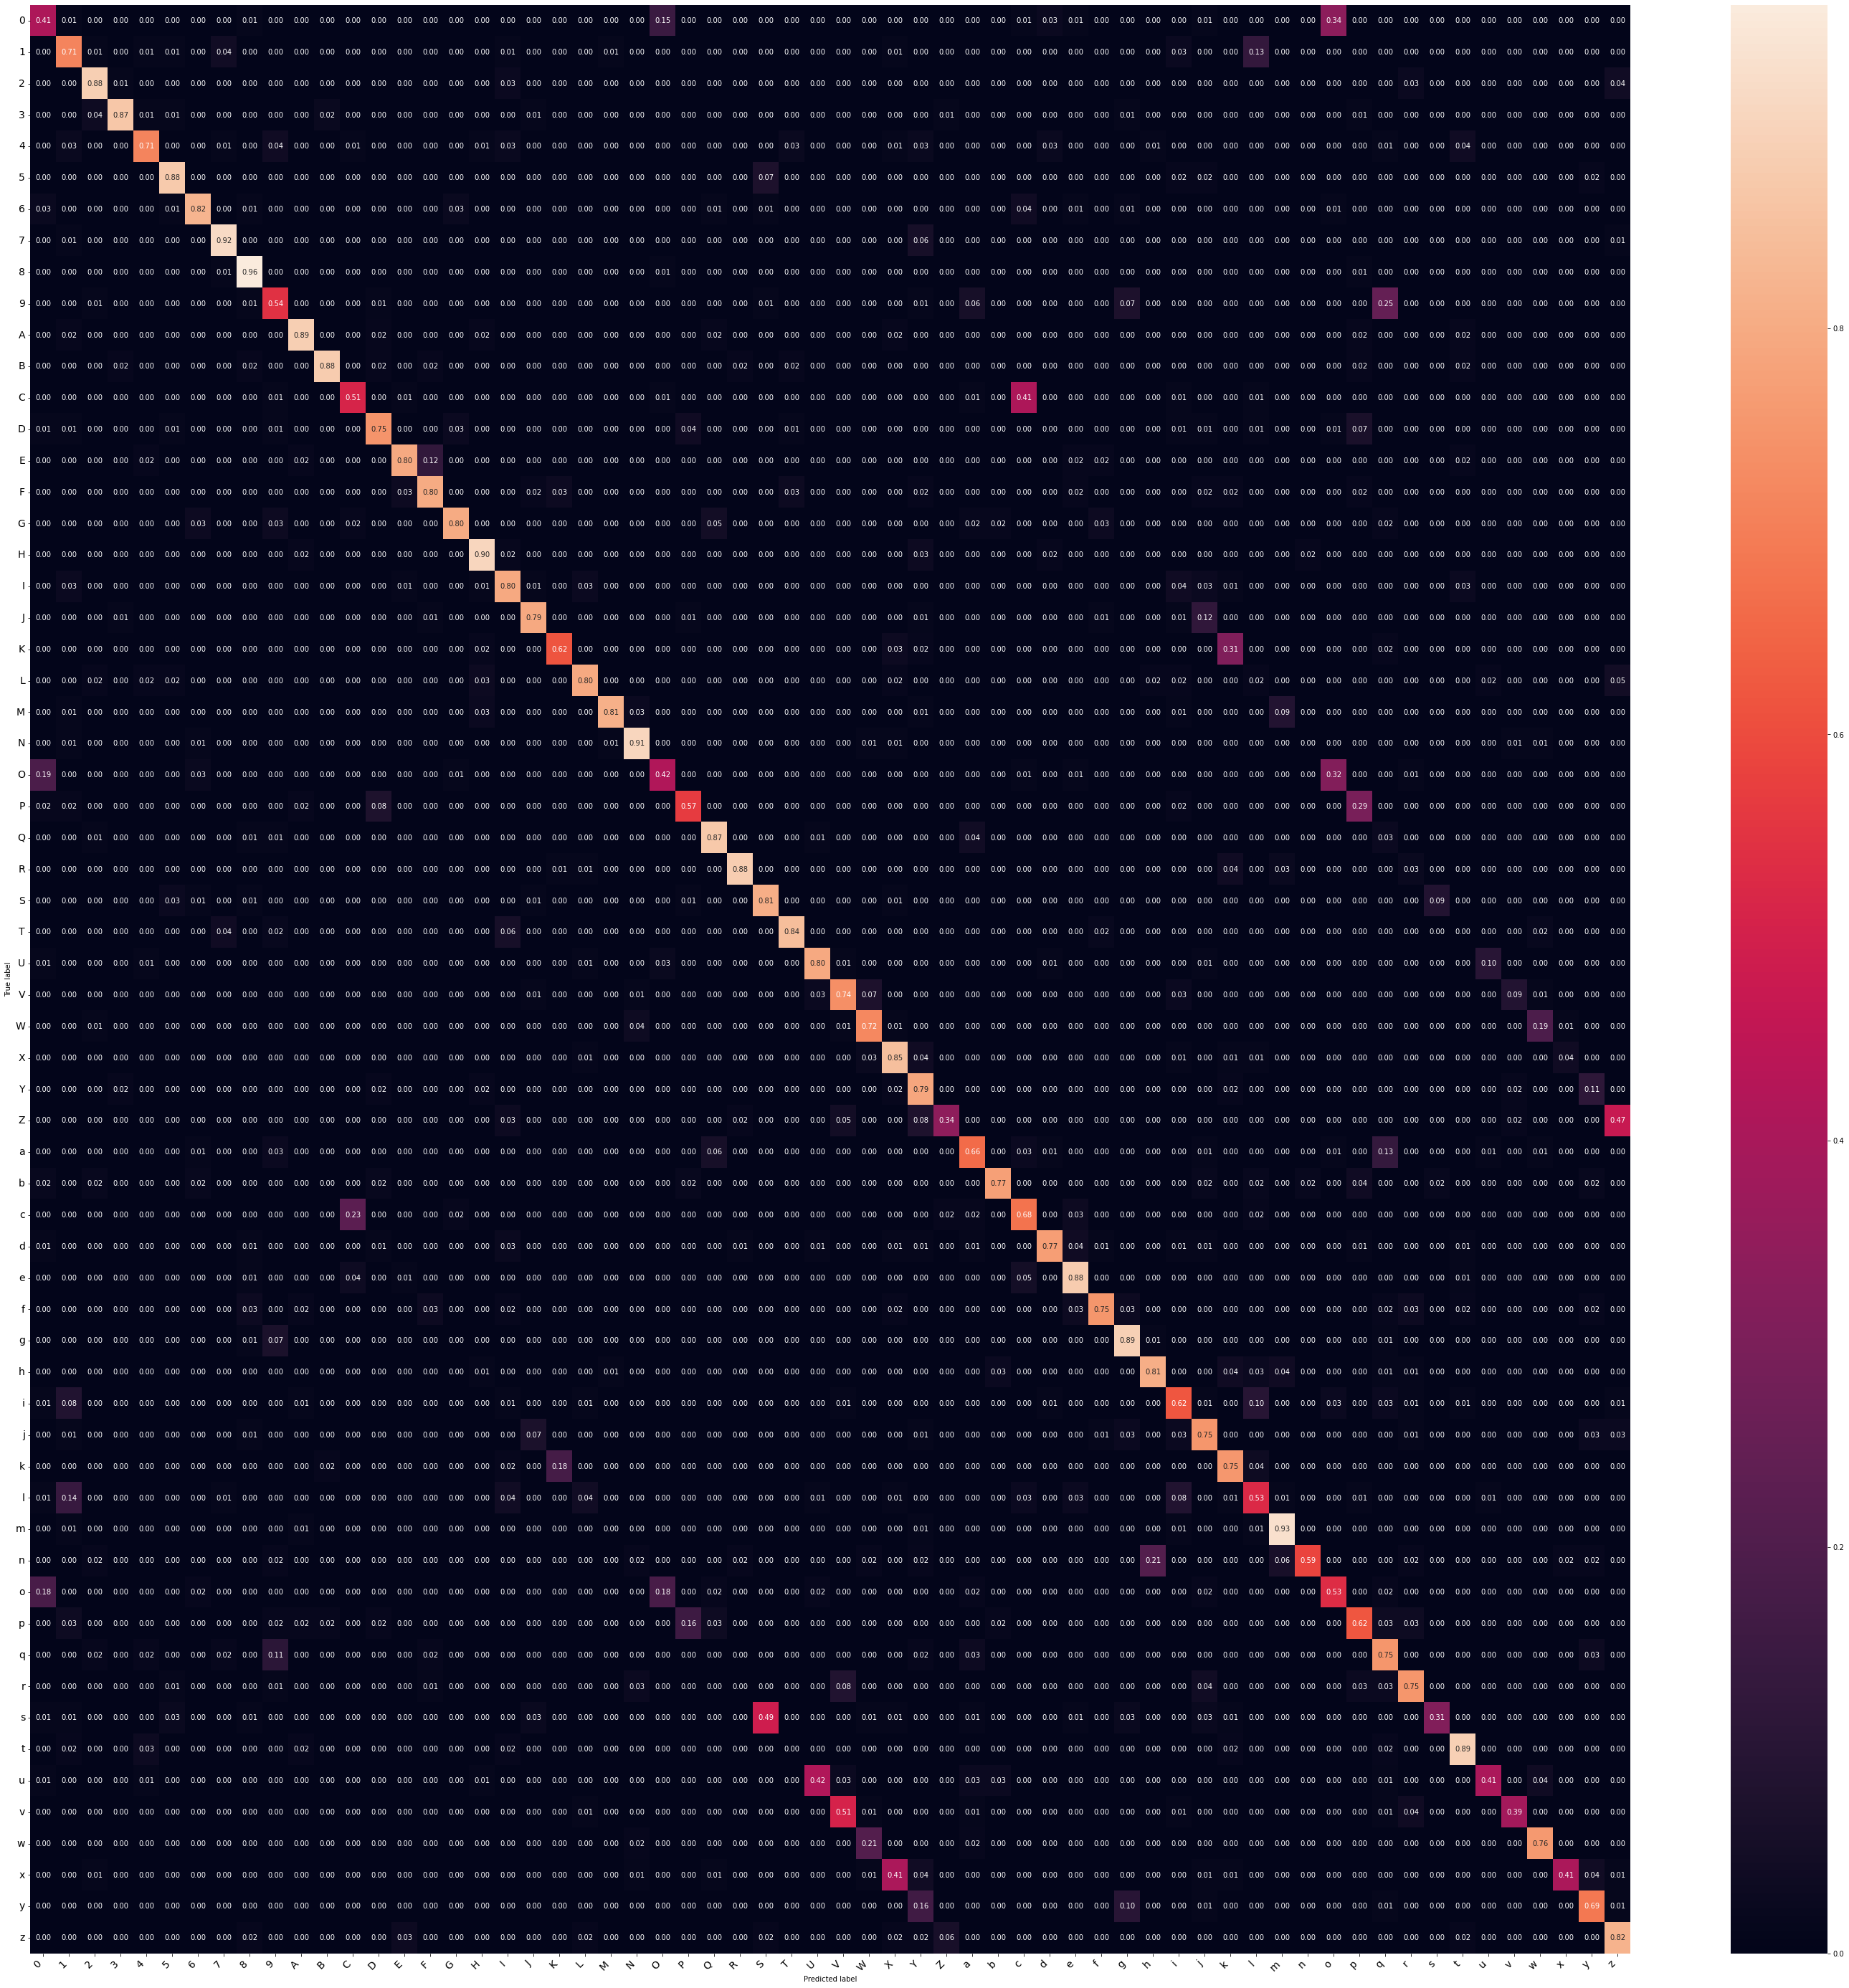

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predict)
#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A','B', 'C', 'D', 'E', 'F', 'G', 'H', 
    #               'I', 'J', 'K', 'L','M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W','X', 'Y', 'Z']


#class_names = ['0,O,o','1,I,i,l ','2,Z,z','3','4','5,S,s','6,G','7','8','9,a,g,q','A',
 #               'B', 'C,c', 'D,P,p,b', 'E,e', 'F,f', 'H,h', 'J,j ', 'K,k', 'L',
  #                 'M,m', 'N,n', 'Q','R','T,t', 'U,V,u,v', 'W,w','X,x', 'Y,y', 'd'] 

class_names = ['0','1','2','3','4','5','6','7','8','9','A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
              'M', 'N', 'O', 'P', 'Q', 'R', 'S','T', 'U', 'V', 'W','X', 'Y', 'Z','a','b', 'c', 'd', 'e', 'f', 'g', 'h',
                'i', 'j', 'k', 'l','m', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w','x', 'y', 'z'] 
print_confusion_matrix(conf_matrix, class_names)
plt.savefig('Confusion_Matix(62).png', dpi=300)

In [ ]:
report = classification_report(y_test, y_predict,target_names= ['0,O,o','1,I,i,l ','2,Z,z','3','4','5,S,s','6,G','7','8','9,a,g,q','A',
                'B', 'C,c', 'D,P,p,b', 'E,e', 'F,f', 'H,h', 'J,j ', 'K,k', 'L',
                   'M,m', 'N,n', 'Q','R','T,t', 'U,V,u,v', 'W,w','X,x', 'Y,y', 'd'] )

In [ ]:
%%capture cap --no-stderr
print(report)

In [ ]:
with open('Classification_Report(30).txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
from collections import Counter


correct = [pred == true for pred, true in zip(y_predict, y_test)]
correct = np.array(correct).flatten()
print(Counter(correct))

Counter({True: 3408, False: 862})


In [ ]:
YY = np.array(y_test).flatten()
classifiedIndexes = np.where(y_test==y_predict)[0]
misclassifiedIndexes = np.where(y_test!=y_predict)[0]

In [ ]:
MM = misclassifiedIndexes

In [ ]:
import matplotlib.pyplot as plt
  
for i in MM:
  A = i
  P = y_predict[A]
  Y = y_test[A]
  x_test = np.reshape(X_test,(4270,2,66))
  X = x_test
  XX = X[A] 

  x = XX[0]
  y= XX[1]

  plt.plot(x, y)

  #plt.plot(x, y)
  plt.title( "." + str(i) + "." + str(Y) + "." + str(P) + ".")
  plt.savefig("/content/sample_data/Result_62/" + str(i) + "." + str(Y) + "." + str(P) + ".png")
  plt.clf()
  plt.close()